In [1]:
import jax

import jax.numpy as np
import jax.scipy as sp

import paragami

import matplotlib.pyplot as plt
%matplotlib inline

from bnpmodeling_runjingdev import log_phi_lib, cluster_quantities_lib
import bnpmodeling_runjingdev.functional_sensitivity_lib as func_sens_lib
import bnpmodeling_runjingdev.exponential_families as ef

from vb_lib import structure_model_lib, plotting_utils
from vb_lib import structure_optimization_lib as s_optim_lib

import re

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
import numpy as onp 
onp.random.seed(53453)

# File paths

In [3]:
scratch_dir = '/scratch/users/genomic_times_series_bnp/structure/' # scratch directory
out_folder = scratch_dir + 'hgdp_fits/' # folder where fits are found

out_filename = 'huang2011_fit' # name of fit

In [4]:
# initial fit and linear response derivatives
alpha0 = 6.0

init_fit_file = out_folder + out_filename + '_alpha' + str(alpha0) + '.npz'
lr_file = out_folder + out_filename + '_alpha' + str(alpha0) + '_lrderivatives.npz'

# check paths exist
assert os.path.isfile(init_fit_file)
assert os.path.isfile(lr_file)

# Load initial fit and meta data

In [5]:
print('initial fit file: ', init_fit_file)

vb_opt_dict, vb_params_paragami, \
        prior_params_dict, prior_params_paragami, \
            gh_loc, gh_weights, init_fit_meta_data = \
                structure_model_lib.load_structure_fit(init_fit_file)

alpha0 = prior_params_dict['dp_prior_alpha']
vb_opt = vb_params_paragami.flatten(vb_opt_dict, free = True)

print('Init optim time: {:.3f}secs'.format(init_fit_meta_data['optim_time']))

initial fit file:  /scratch/users/genomic_times_series_bnp/structure/hgdp_fits/huang2011_fit_alpha6.0.npz
Init optim time: 4580.959secs


`vb_opt_dict` contains the parameters at the initial ($\epsilon = 0)$ fit. 

The parameter dictionary contains two keys: 
- `pop_freq_beta_params`: a (`n_loci` x `k_approx` x 2) array of Beta parameters that describe the approximate posterior on population allele frequencies. (these are the "cluster centroids").
- `ind_admix_params`: contain the logit-normal parameters on the stick-breaking proportions. This is yet another dictionary with two keys, `stick_means` and `stick_infos`. Each are (`n_obs` x `k_approx - 1`). 

In [6]:
print(vb_params_paragami)

OrderedDict:
	[pop_freq_beta_params] = NumericArrayPattern (2810, 20, 2) (lb=0.0, ub=inf)
	[ind_admix_params] = OrderedDict:
	[stick_means] = NumericArrayPattern (1107, 19) (lb=-inf, ub=inf)
	[stick_infos] = NumericArrayPattern (1107, 19) (lb=0.0, ub=inf)


The `ind_admix_params` are of particular importance, as they define the expected number of clusters. 

We can compute, for example, the expected stick-breaking proportions (shape is `n_obs x k_approx - 1`, a stick-breaking process for each individual): 

In [7]:
stick_means = vb_opt_dict['ind_admix_params']['stick_means']
stick_infos = vb_opt_dict['ind_admix_params']['stick_infos']
    
e_sticks = ef.get_e_logitnormal(stick_means, stick_infos, gh_loc, gh_weights)

print(e_sticks.shape)

(1107, 19)


We can also compute the expected individual mixture proportions. 

This is an array of shape `n_obs x k_approx`, where the $(n,k)$-th entry is the posterior probability of individual $n$ belonging to cluster $k$. 

In [8]:
e_ind_admix = cluster_quantities_lib.get_e_cluster_probabilities(stick_means, 
                                                                 stick_infos, 
                                                                 gh_loc, 
                                                                 gh_weights)

print(e_ind_admix.shape)

(1107, 20)


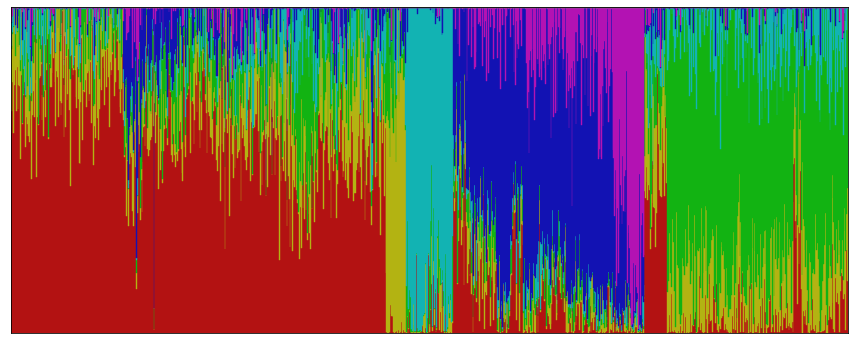

In [9]:
# plot expected mixture proportions

fig, ax = plt.subplots(1, 1, figsize = (15, 6))

# top 6 clusters are colored ... remaining clusters are grey
# height of bar represents mixture proportions
plotting_utils.plot_top_clusters(e_ind_admix, ax, n_top_clusters = 6); 

# Define perturbation

This class contains a collection of perturbations. 

In [10]:
f_obj_all = log_phi_lib.LogPhiPerturbations(vb_params_paragami, 
                                            prior_params_dict['dp_prior_alpha'],
                                            gh_loc, 
                                            gh_weights,
                                            stick_key = 'ind_admix_params')

Choose a perturbation. Available perturbations are: 

- 'worst-case', the worst-case L-inf perturbation
- 'sigmoidal_pos', the perturbation where log-phi is a sigmoid function
- 'sigmoidal_neg', the perturbation where log-phi is the negative sigmoid function
- 'alpha_pert_pos', the multiplicative functional perturbation to move the DP alpha parameter by +5
- 'alpha_pert_neg', the multiplicative functional perturbation to move the DP alpha parameter by -5

In [11]:
# choose a perturbation
perturbation = 'sigmoidal_neg'
f_obj = getattr(f_obj_all, 'f_obj_' + perturbation)

`f_obj` contains a few important methods for fitting and computing the linear response. For this notebook, the important one (really just for plotting) is the `log_phi` method, which returns log multiplicative perturbation. 

(other methods include expecations of log-phi). 

In [12]:
log_phi = f_obj.log_phi

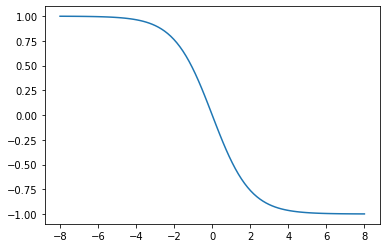

In [13]:
# The log-phi
# (we will plot the effect on the prior later)
logit_v_grid = np.linspace(-8, 8, 100)
plt.plot(logit_v_grid, log_phi(logit_v_grid))

# Define linear sensitivity

In [14]:
print('loading derivatives from: ', lr_file)
lr_data = np.load(lr_file)

# check some stuff: make sure it matches the intial fit
assert lr_data['alpha0'] == alpha0 # check alphas match
assert np.abs(lr_data['vb_opt'] - vb_opt).max() < 1e-12 # check optimum match
assert np.abs(lr_data['kl'] - init_fit_meta_data['final_kl']) < 1e-8 # check KL's match

loading derivatives from:  /scratch/users/genomic_times_series_bnp/structure/hgdp_fits/huang2011_fit_alpha6.0_lrderivatives.npz


In [15]:
dinput_dfun = lr_data['dinput_dfun_' + perturbation]

For this derivative, I lowered to CG tolerance to rule out a bad solver ... 

Hence the derivative time is so large (with default tolerance of 1e-2, derivative should only take a minute)

In [16]:
print('Derivative time: {:.02f} secs'.format(lr_data['lr_time_' + perturbation]))
print('CG tolerance: ', lr_data['cg_tol'])

Derivative time: 2433.62 secs
CG tolerance:  1e-08


# Load refits

In [17]:
match_crit = out_filename + '_' + perturbation + '\d+.npz'
refit_files = [f for f in os.listdir(out_folder) if re.match(match_crit, f)]
    
assert len(refit_files) > 0, 'no refit files found'

In [18]:
def load_refit_files(refit_files): 
    
    # load files
    optim_time_vec = [init_fit_meta_data['optim_time']]
    epsilon_vec = [0.]
    vb_refit_list = [vb_opt]
    delta = []
    
    for i in range(len(refit_files)): 

        print('loading fit from: ', refit_files[i])
        vb_params_dict, vb_params_paragami, meta_data = \
            paragami.load_folded(out_folder + refit_files[i])
        
        vb_free = vb_params_paragami.flatten(vb_params_dict, free = True)
                
        # save the metadata we need
        optim_time_vec.append(meta_data['optim_time'])
        epsilon_vec.append(meta_data['epsilon'])
        vb_refit_list.append(vb_free)
        
        # for the sigmoidal perturbation, we scaled the original function 
        # by a factor delta.
        # Save this delta
        delta.append(meta_data['delta'])
        
    optim_time_vec = np.array(optim_time_vec)
    epsilon_vec = np.array(epsilon_vec)
    vb_refit_list = np.array(vb_refit_list)
    
    # all the delta's should be the same ... 
    delta = np.unique(np.array(delta))
    print('delta = ', delta)
    assert len(delta) == 1
    
    # sort the epsilons 
    _indx = np.argsort(epsilon_vec)
    optim_time_vec = optim_time_vec[_indx]
    epsilon_vec = epsilon_vec[_indx]
    vb_refit_list = vb_refit_list[_indx]
    
    return vb_refit_list, epsilon_vec, optim_time_vec, delta

In [19]:
vb_refit_list, epsilon_vec, optim_time_vec, delta = \
    load_refit_files(refit_files)

loading fit from:  huang2011_fit_sigmoidal_neg14.npz
loading fit from:  huang2011_fit_sigmoidal_neg13.npz
loading fit from:  huang2011_fit_sigmoidal_neg2.npz
loading fit from:  huang2011_fit_sigmoidal_neg5.npz
loading fit from:  huang2011_fit_sigmoidal_neg12.npz
loading fit from:  huang2011_fit_sigmoidal_neg15.npz
loading fit from:  huang2011_fit_sigmoidal_neg4.npz
loading fit from:  huang2011_fit_sigmoidal_neg3.npz
loading fit from:  huang2011_fit_sigmoidal_neg9.npz
loading fit from:  huang2011_fit_sigmoidal_neg0.npz
loading fit from:  huang2011_fit_sigmoidal_neg7.npz
loading fit from:  huang2011_fit_sigmoidal_neg18.npz
loading fit from:  huang2011_fit_sigmoidal_neg16.npz
loading fit from:  huang2011_fit_sigmoidal_neg11.npz
loading fit from:  huang2011_fit_sigmoidal_neg6.npz
loading fit from:  huang2011_fit_sigmoidal_neg1.npz
loading fit from:  huang2011_fit_sigmoidal_neg8.npz
loading fit from:  huang2011_fit_sigmoidal_neg10.npz
loading fit from:  huang2011_fit_sigmoidal_neg17.npz
del

`vb_refit_list` contains the free parameters from each refit. 

`vb_refit_list[i]` corresponds to the refit with `epsilon = epsilon_vec[i]`. 

# Get linear approximation to the refits

In [20]:
def predict_opt_par_from_hyper_par(epsilon): 
    return vb_opt + dinput_dfun * epsilon * delta

lr_list = []
for epsilon in epsilon_vec: 
    # get linear response
    lr_list.append(predict_opt_par_from_hyper_par(epsilon))


`lr_list` contains the free parameters from the linear approximation. 

`lr_list[i]` corresponds to the predicted free parameters for `epsilon = epsilon_vec[i]`. 

# Define number of clusters

We consider the number of clusters we expect to see if a new loci were observed for each individual. 

This is computed in the following steps: 

(1) Sample stick-breaking proportions $\nu_{n1}, ..., \nu_{nK}$ from $q$. 

(2) Construct individual mixture proportions $\pi_{n1}, ..., \pi_{nK}$ from stick-breaking proportions: 

\begin{align}
\pi_{nk} = \nu_{nk} \prod_{j = 1}^{k - 1}(1 - \nu_{nj})
\end{align}

(3) Compute expected number of clusters from mixture proportions: 
\begin{align}
K - \sum_{k = 1}^K \prod_{n = 1}^N (1 - \pi_{nk})
\end{align}


**We simplify this** (for debugging purposes) by replacing samples of $\nu$ in step (1) with their expectations. Therefore, the function from variational parameters to expected number of clusters is deterministic. 

In [21]:
def get_e_ind_admix(vb_free_params): 
    
    # this returns the expected individual mixture proportions. 
    
    # this is step 1 and 2 above, where the sticks are not sampled, but 
    # rather evaluated at their expections -- hence a deterministic function. 
    
    vb_params_dict = vb_params_paragami.fold(vb_free_params, free = True)
    
    stick_means = vb_params_dict['ind_admix_params']['stick_means']
    stick_infos = vb_params_dict['ind_admix_params']['stick_infos']
    
    e_ind_admix = cluster_quantities_lib.get_e_cluster_probabilities(stick_means, 
                                                                     stick_infos, 
                                                                     gh_loc, 
                                                                     gh_weights)
    
    return e_ind_admix
    
def g(vb_free_params): 
    
    # step 1 and 2
    e_ind_admix = get_e_ind_admix(vb_free_params)
    
    
    # returns the expected number of clusters (step 3)
    return cluster_quantities_lib.get_e_num_clusters_from_ez(e_ind_admix)

# Functions to plot results

In [22]:
def get_e_num_clusters_vec(param_list): 
    e_num_cluster_vec = onp.zeros(len(param_list))
    
    for i in range(len(param_list)): 
        e_num_cluster_vec[i] = g(param_list[i])
        
    return e_num_cluster_vec

In [23]:
def plot_e_num_clusters(vb_refit_list, lr_list, epsilon_vec, ax): 
        
    assert len(vb_refit_list) == len(lr_list)
    assert len(vb_refit_list) == len(epsilon_vec)
    
    # get expected number of clusters
    print('Computing expected number of clusters ... ')
    
    refit_e_num_clusters_vec = get_e_num_clusters_vec(vb_refit_list)
    lr_e_num_clusters_vec = get_e_num_clusters_vec(lr_list)
    
    # plot
    ax.plot(epsilon_vec, refit_e_num_clusters_vec, 
           'o-', color = '#d95f02', label = 'refit')

    ax.plot(epsilon_vec, lr_e_num_clusters_vec, 
               'o-', color = '#1b9e77', 
               label = 'linear approx.')

    ax.legend()
    
    return refit_e_num_clusters_vec, lr_e_num_clusters_vec, epsilon_vec

# Plot results

Computing expected number of clusters ... 


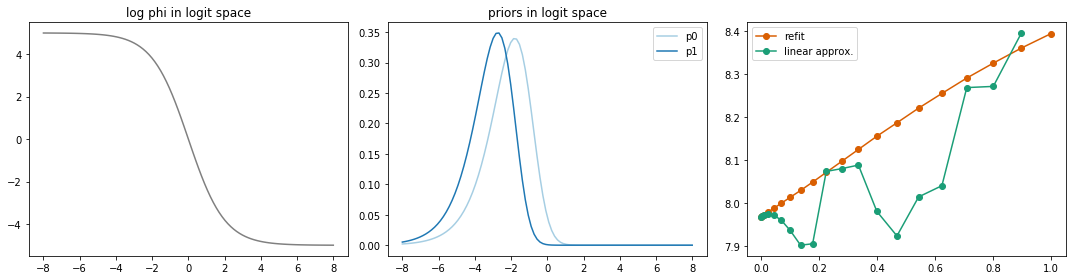

In [24]:
fig, ax = plt.subplots(1, 3, figsize = (15, 4)) 

######################
# plot perturbation
######################
prior_perturbation = func_sens_lib.PriorPerturbation(
                                    alpha0 = prior_params_dict['dp_prior_alpha'],
                                    log_phi = lambda x : log_phi(x) * delta, 
                                    logit_v_ub = 10, 
                                    logit_v_lb = -10)
        
# plot log-phi
logit_v_grid = np.linspace(-8, 8, 100)
ax[0].plot(logit_v_grid, 
         prior_perturbation.log_phi(logit_v_grid), 
         color = 'grey')
ax[0].set_title('log phi in logit space')

######################
# plot priors
######################
ax[1].plot(logit_v_grid, 
         np.exp(prior_perturbation.get_log_p0_logit(logit_v_grid)), 
         color = '#a6cee3', label = 'p0')
ax[1].plot(logit_v_grid, 
         np.exp(prior_perturbation.get_log_pc_logit(logit_v_grid)), 
         color = '#1f78b4', label = 'p1')

ax[1].set_title('priors in logit space')
ax[1].legend()

######################
# plot number of clusters
######################
plot_e_num_clusters(vb_refit_list, lr_list, epsilon_vec, ax[2])

fig.tight_layout()

# Some other exploratory plots

In [25]:
def print_diff_plot(lr_vb_free_params, vb_opt_pert, vb_opt, ax, color = 'red'): 
    ax.plot(lr_vb_free_params - vb_opt, 
             vb_opt_pert - vb_opt, 
             '+', color = color)

    ax.plot(lr_vb_free_params - vb_opt, 
            lr_vb_free_params - vb_opt, 
             '-', color = 'blue')

### Predicted diff. against refitted diff.

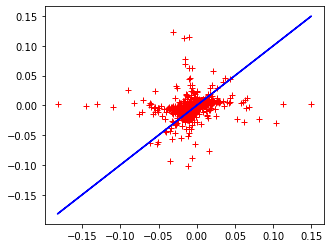

In [26]:
assert np.all(vb_refit_list[0] == lr_list[0])
fig0, ax0 = plt.subplots(1, 1, figsize = (5, 4))

# this is at the smallest epsilon ... 
print_diff_plot(lr_list[1], vb_refit_list[1], vb_refit_list[0], ax0, color = 'red')

### diff in stick means

In [27]:
# free = False means that we are plotting the free parameters (we don't constrain them)
init_stick_means = vb_params_paragami.fold(vb_refit_list[0], free = False)['ind_admix_params']['stick_means']
lr_stick_means = vb_params_paragami.fold(lr_list[1], free = False)['ind_admix_params']['stick_means']
refit_stick_means = vb_params_paragami.fold(vb_refit_list[1], free = False)['ind_admix_params']['stick_means']

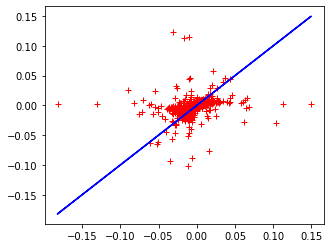

In [28]:
fig0, ax0 = plt.subplots(1, 1, figsize = (5, 4))
print_diff_plot(lr_stick_means.flatten(),
                refit_stick_means.flatten(), 
                init_stick_means.flatten(), ax0, color = 'red')

### diff in stick infos

In [29]:
init_stick_infos = vb_params_paragami.fold(vb_refit_list[0], free = False)['ind_admix_params']['stick_infos']
lr_stick_infos = vb_params_paragami.fold(lr_list[1], free = False)['ind_admix_params']['stick_infos']
refit_stick_infos = vb_params_paragami.fold(vb_refit_list[1], free = False)['ind_admix_params']['stick_infos']

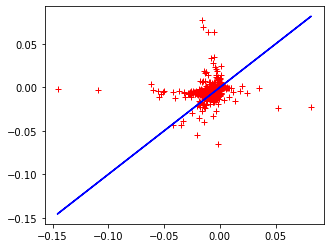

In [30]:
fig0, ax0 = plt.subplots(1, 1, figsize = (5, 4))
print_diff_plot(lr_stick_infos.flatten(),
                refit_stick_infos.flatten(), 
                init_stick_infos.flatten(), ax0, color = 'red')

# Look at what happens under the hood to stick-breaking proportions

We look at the individual steps (1) and (2) in computing the expected number of clusters

In [41]:
def plot_stick_components(stick_fun, n_indx, k_sub = 6): 
    refit_array = []
    lr_array = []

    for i in range(len(epsilon_vec)): 
        refit_array.append(stick_fun(vb_refit_list[i]))
        lr_array.append(stick_fun(lr_list[i]))

    lr_array = np.array(lr_array)
    refit_array = np.array(refit_array)
    
    for n in n_indx: 

        fig, ax = plt.subplots(1, k_sub, figsize = (24, 4))
        fig.tight_layout()

        for k in range(k_sub): 
            ax[k].plot(epsilon_vec, lr_array[:, n, k], '-x', color = 'red', label = 'lr')
            ax[k].plot(epsilon_vec, refit_array[:, n, k], '-x', color = 'blue', label = 'refit')
            ax[k].set_xlabel('epsilon')

            if k == 0: 
                ax[k].legend()

### First look at logit-normal location parameter

In [42]:
n_obs = e_ind_admix.shape[0]

[1019]


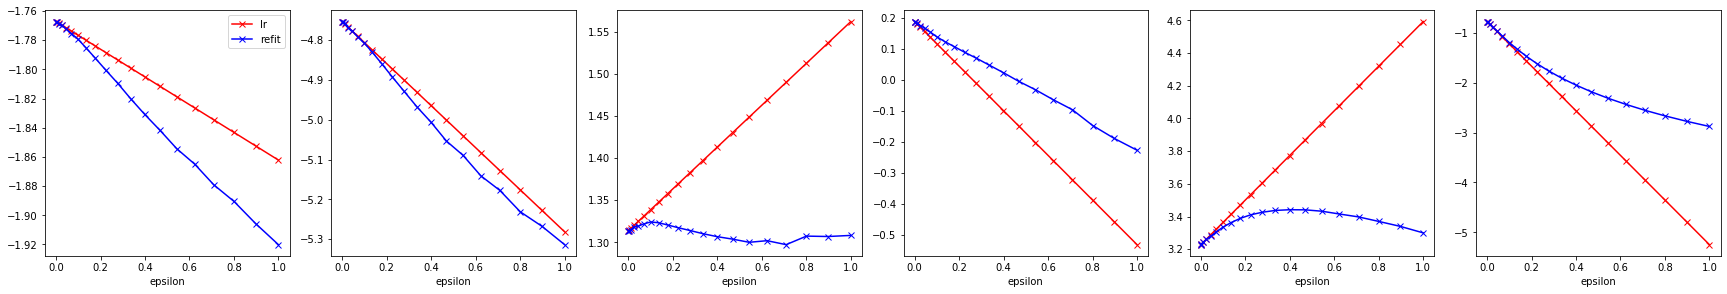

In [43]:
# choose an individual 
obs_indx = onp.random.choice(n_obs, (1,))
print(obs_indx)

# we look at this individual's first `k_sub sticks`
k_sub = 6

# function that returns means
def get_logitnormal_mean_param(vb_free_params): 
    vb_params_dict = vb_params_paragami.fold(vb_free_params, free = True)
    return vb_params_dict['ind_admix_params']['stick_means']

plot_stick_components(get_logitnormal_mean_param, obs_indx)

### effect on logit-location information

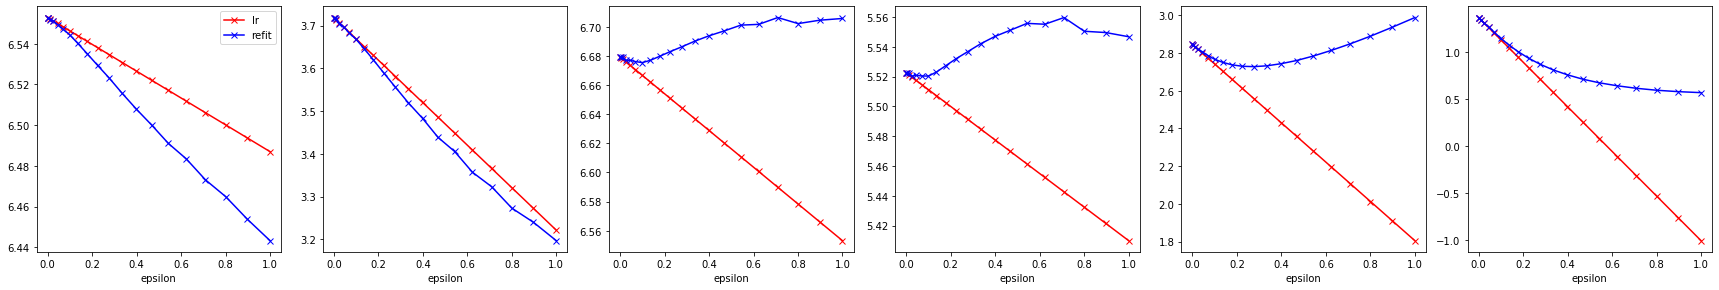

In [44]:
def get_logitnormal_info_param(vb_free_params): 
    vb_params_dict = vb_params_paragami.fold(vb_free_params, free = True)
    return np.log(vb_params_dict['ind_admix_params']['stick_infos'])

plot_stick_components(get_logitnormal_info_param, obs_indx)

### On expectation of sticks

In [45]:
def get_e_sticks(vb_free_params): 
    vb_params_dict = vb_params_paragami.fold(vb_free_params, free = True)
    
    lognorm_means = vb_params_dict['ind_admix_params']['stick_means']
    lognorm_infos = vb_params_dict['ind_admix_params']['stick_infos']
    
    return ef.get_e_logitnormal(lognorm_means, lognorm_infos, gh_loc, gh_weights)

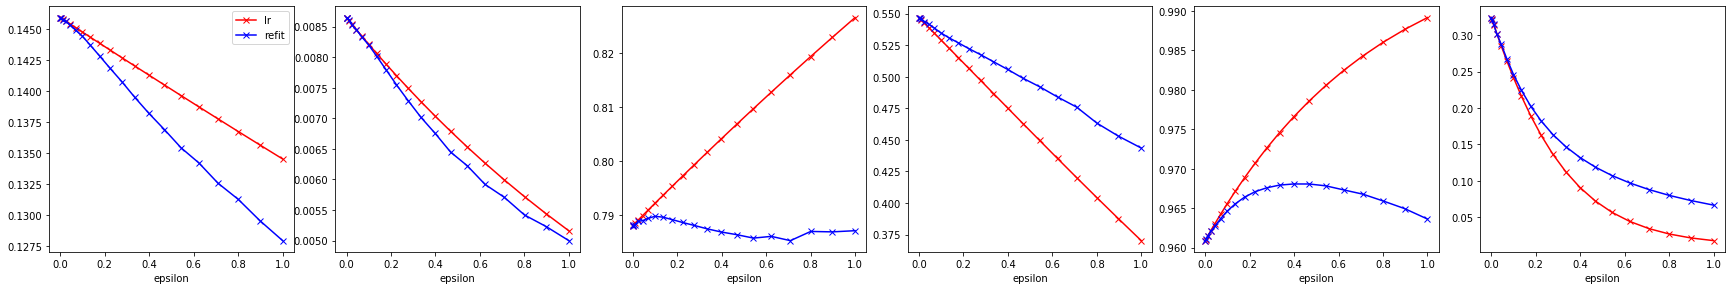

In [46]:
plot_stick_components(get_e_sticks, obs_indx)

### On mixture proportions

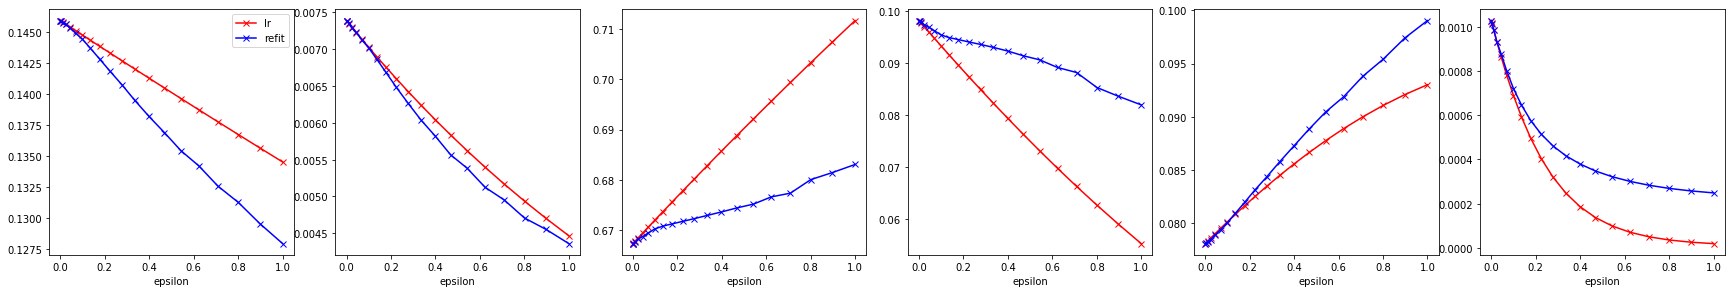

In [47]:
plot_stick_components(lambda x : get_e_ind_admix(x), obs_indx)